In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier


from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import preprocessing


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

from math import ceil

import warnings
#warnings.filterwarnings("ignore")

In [2]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

In [3]:
df_train = pd.read_csv("df_train_processed.csv")

In [4]:
df_train = df_train.drop(columns=['actor'])

In [5]:
df_train['sex'].value_counts()

M    936
F    892
Name: sex, dtype: int64

## Standardization

In [6]:
df_train_num = df_train.select_dtypes(include="number")
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [7]:
df_train_model = df_train

In [8]:
label_encoder = preprocessing.LabelEncoder()
df_train_model['sex']= label_encoder.fit_transform(df_train_model['sex'])

In [9]:
df_train_model = pd.get_dummies(df_train_model)

In [10]:
df_sex_train = df_train_model

In [11]:
df_sex_train.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q50,...,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised,emotional_intensity_normal,emotional_intensity_strong,statement_Dogs are sitting by the door,statement_Kids are talking by the door,repetition_1st,repetition_2nd
0,0.107840,0.385871,0.435971,0.022102,0.967474,0.036119,0.979319,0.978418,0.998047,0.25,...,0,1,0,0,1,0,0,1,1,0
1,0.117646,0.385792,0.435878,0.023967,0.963262,0.043729,0.977355,0.977549,0.998047,0.25,...,0,1,0,0,1,0,0,1,0,1
2,0.098033,0.385883,0.435989,0.029249,0.968888,0.054101,0.972723,0.972712,1.000000,0.25,...,0,1,0,0,1,0,1,0,1,0
3,0.068626,0.385857,0.435972,0.027946,0.969257,0.058336,0.974555,0.975069,0.998047,0.25,...,0,1,0,0,1,0,1,0,0,1
4,0.176466,0.385852,0.435923,0.015209,0.979741,0.021665,0.985816,0.984619,0.998047,0.25,...,0,0,0,0,1,0,0,1,1,0


## Rendere training dataset imbalanced

In [12]:
def dip_indp_variables(data,target):
    
    X = np.array(data.loc[:, data.columns != target])
    
    y = np.array(data.loc[:, data.columns == target])
    
    result = np.unique(y, return_counts=True)
    
    return  {'X': X,
             'y': y,
             'result': { result[0][0] : result[1][0],
                       result[0][1] : result[1][1]}
           }

In [13]:
dip_indp_variables_train = dip_indp_variables(df_sex_train,"sex")

In [14]:
dip_indp_variables_train['result']

{0: 892, 1: 936}

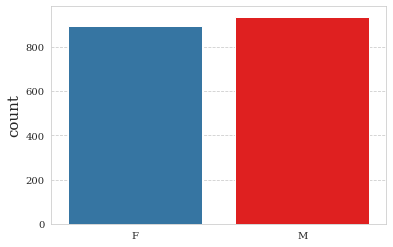

In [15]:
labels = ['F','M']
ax=sns.countplot(x=df_sex_train['sex'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'Before_Imbalancing_Sex' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [16]:
def rows_to_remove(data,target,num, dataset):
    
    y = dataset['y']
    
    majority_class = list(dataset['result'].keys())[1]
    
    total_majority_class = dataset['result'][majority_class]
    
    rows_remove = np.random.choice((data[y == majority_class]).index, total_majority_class-num, replace=False)
    
    df_target = data.drop(index=rows_remove, axis=0)
    
    return {'df_target': df_target,
            'rows_remove': rows_remove}

In [17]:
rows_remove_train = rows_to_remove(df_sex_train,"sex", 37, dip_indp_variables_train)

In [18]:
def drop_rows(data, rows_dataset):
    
    df_after_remove = data.drop(index=rows_dataset['rows_remove'], axis=0)
    
    return {'df_after_remove': df_after_remove}

In [19]:
drop_rows_train = drop_rows(df_sex_train, rows_remove_train)

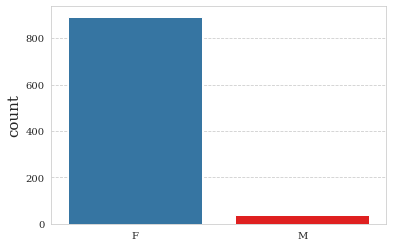

In [20]:
labels = ['F','M']
ax=sns.countplot(x=drop_rows_train['df_after_remove']['sex'], palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
img_name = 'After_Imbalancing_Sex' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [21]:
def dip_indip_after_remove(data, target, rows, dip_indp_variables_dataset):
    
    X2 = data.loc[:, data.columns != target]
    
    y2 = np.array([dip_indp_variables_dataset['y'][i] for i in range(len(dip_indp_variables_dataset['y'])) if i not in rows])
    
    result = np.unique(y2, return_counts=True)
    
    return {'X2': X2,
            'y2': y2,
            'result': { result[0][0] : result[1][0],
                      result[0][1] : result[1][1]}
           }

In [22]:
dip_indip_after_remove_train = dip_indip_after_remove(drop_rows_train['df_after_remove'], 
                                                'sex',
                                                rows_remove_train['rows_remove'], dip_indp_variables_train)

In [23]:
X2 = np.array(dip_indip_after_remove_train['X2'])
y2 = np.array(dip_indip_after_remove_train['y2'].ravel())


In [24]:
np.unique(y2, return_counts=True)

(array([0, 1]), array([892,  37]))

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=100)

In [26]:
X_train.shape

(650, 392)

In [27]:
from sklearn.manifold import TSNE

In [28]:
def perform_tsne(X_data, y_data,img_name_prefix):
        
        X_reduced = TSNE(random_state=42).fit_transform(X_data)
     

        df = pd.DataFrame({'Dim 1':X_reduced[:,0], 'Dim 2':X_reduced[:,1] ,'label':y_data})
        
   
        
        sns.lmplot(data=df, x='Dim 1', y='Dim 2', hue='label', fit_reg=False, height=8,\
                   palette="Set1",legend=False)
 
        plt.legend( loc='upper right', labels=['F', 'M'])
        img_name = img_name_prefix + '.png'
        
       
        #plt.savefig(img_name,dpi=300, bbox_inches='tight')
        plt.show()
        

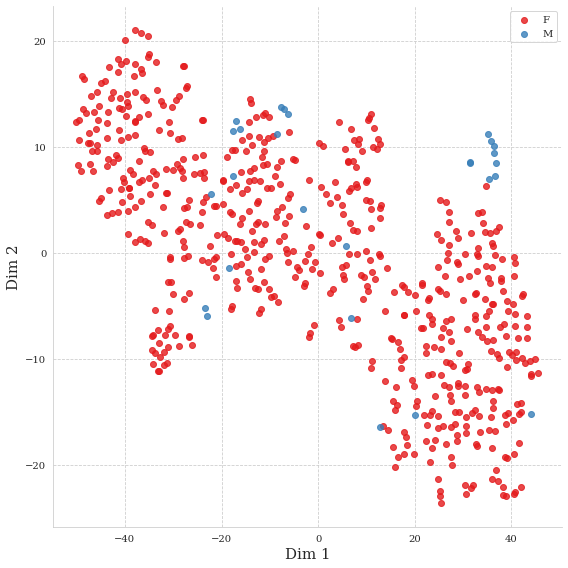

In [29]:
perform_tsne(X_train,y_train, 'Imbalance_Sex')

## Decision Tree before Undersampling/Oversampling

In [30]:
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

In [57]:
def Decision_tree(X_train_array, y_train_array):
    param_grid = {
        "min_samples_split": loguniform(1e-2, 1e0),
        "min_samples_leaf": uniform(0.001, 0.2),
        "max_depth": randint(2, 200),
        "criterion": ["gini", "entropy", "log_loss"],
    }
    
    tree = DecisionTreeClassifier(random_state=42)
    
    tree_cv = RandomizedSearchCV(tree, param_grid, cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
            n_jobs=None,
            n_iter=200, error_score='raise')
    
    
    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [58]:
decision_tree = Decision_tree(X_train, y_train)

In [59]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 151, 'min_samples_leaf': 0.02525526155689999, 'min_samples_split': 0.01097390948657634}


In [60]:
model_tree = DecisionTreeClassifier(criterion = 'gini', 
                                    max_depth = 151,
                                    min_samples_leaf = 0.02525526155689999, 
                                    min_samples_split = 0.01097390948657634)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=151, min_samples_leaf=0.02525526155689999,
                       min_samples_split=0.01097390948657634)

In [61]:
y_pred_decision_tree = model_tree.predict(X_test)

In [62]:
def metrics_model(test, predict, majority_class, minority_class):
    new_dic = {}
    new_dic['accuracy'] = accuracy_score(predict, test)
    #new_dic['precision (' + majority_class + ')'] = precision_score(test, predict, average=None)[0]
    #new_dic['precision (' + minority_class + ')'] = precision_score(test, predict, average=None)[1]
    #new_dic['recall (' + majority_class + ')'] = recall_score(test, predict, average=None)[0]
    #new_dic['recall (' + minority_class + ')'] = recall_score(test, predict, average=None)[1]
    new_dic['f1_score (' + majority_class + ')'] = f1_score(test, predict,average=None)[0]
    new_dic['f1_score (' + minority_class + ')'] = f1_score(test, predict,average=None)[1]
    
    return new_dic

In [63]:
data_decision_tree = metrics_model(y_test, y_pred_decision_tree, 'F', 'M')
data_decision_tree

{'accuracy': 0.974910394265233,
 'f1_score (F)': 0.9871086556169429,
 'f1_score (M)': 0.5333333333333333}

In [64]:
print(classification_report(y_test, y_pred_decision_tree))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       269
           1       0.80      0.40      0.53        10

    accuracy                           0.97       279
   macro avg       0.89      0.70      0.76       279
weighted avg       0.97      0.97      0.97       279



## KNN before Undersampling/Oversampling

In [65]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = stats.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [66]:
df_sex_train_knn = spearman_selector(df_train['sex'], df_train, 0.7)

/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [67]:
df_train_cat_knn = df_train.select_dtypes(include=['object'])
df_sex_train = pd.concat([df_sex_train_knn, df_train_cat_knn], axis=1)

In [68]:
df_sex_train = pd.get_dummies(df_sex_train)

In [69]:
dip_indp_variables_knn = dip_indp_variables(df_sex_train,"sex")

In [70]:
dip_indp_variables_knn['X'].shape

(1828, 24)

In [71]:
rows_remove_knn = rows_to_remove(df_sex_train,"sex", 37, dip_indp_variables_knn)

In [72]:
drop_rows_knn = drop_rows(df_sex_train, rows_remove_knn)

In [73]:
dip_indip_after_remove_knn = dip_indip_after_remove(drop_rows_knn['df_after_remove'], 
                                                'sex',
                                                rows_remove_knn['rows_remove'], dip_indp_variables_knn)

In [74]:
X2_knn = np.array(dip_indip_after_remove_knn['X2'])
y2_knn = np.array(dip_indip_after_remove_knn['y2'].ravel())

In [75]:
np.unique(y2_knn, return_counts=True)

(array([0, 1]), array([892,  37]))

In [76]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X2_knn, y2_knn, test_size=0.3, random_state=100)

In [77]:
X_train_knn.shape

(650, 24)

In [79]:
def Knn(X_train_array, y_train_array):   
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': np.arange(2,  X_train_array.shape[0]//2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'cosine', 'chebyshev']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                     parameters,
                    cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
                    n_jobs=None,
                    refit=True,error_score='raise')
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [80]:
knn = Knn(X_train_knn, y_train_knn)

In [81]:
print(knn.best_params_)

{'weights': 'uniform', 'n_neighbors': 207, 'metric': 'cosine'}


In [82]:
model_knn = KNeighborsClassifier(weights = 'uniform', 
                                 n_neighbors = 207, 
                                 metric = 'cosine')
model_knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='cosine', n_neighbors=207)

In [83]:
y_pred_knn = model_knn.predict(X_test_knn)

In [84]:
data_knn = metrics_model( y_test_knn, y_pred_knn, 'F', 'M')
data_knn

{'accuracy': 0.946236559139785,
 'f1_score (F)': 0.9723756906077349,
 'f1_score (M)': 0.0}

In [85]:
print(classification_report(y_test_knn, y_pred_knn))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       264
           1       0.00      0.00      0.00        15

    accuracy                           0.95       279
   macro avg       0.47      0.50      0.49       279
weighted avg       0.90      0.95      0.92       279



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [86]:
def combined_results(data,data1):
    combined_dic = {'Decision_tree': data, 'Knn': data1}
    
    return combined_dic

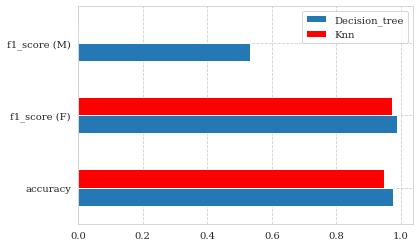

In [87]:
combined_dic = combined_results(data_decision_tree,data_knn)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('Imbalanced_Sex_Result',dpi=300, bbox_inches='tight')
plt.show()

## Undersampling

In [88]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

## Random Undersampling

In [89]:
def randomUnderSampler(X_train_array, y_train_array):
    
    
    rus = RandomUnderSampler(random_state=42)
    
    X_res_rus, y_res_rus = rus.fit_resample(X_train_array, y_train_array)
    
    return X_res_rus, y_res_rus

In [90]:
X_res_rus, y_res_rus = randomUnderSampler(X_train, y_train)

In [91]:
X_res_rus_knn, y_res_rus_knn = randomUnderSampler(X_train_knn, y_train_knn)

In [92]:
print('Resampled dataset shape %s' % Counter(y_res_rus))

Resampled dataset shape Counter({0: 27, 1: 27})


In [93]:
len(X_res_rus)

54

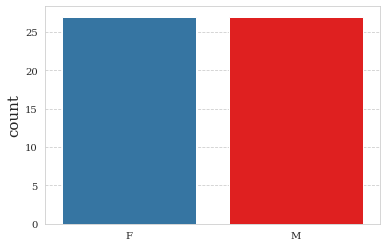

In [94]:
labels = ['F','M']
ax=sns.countplot(x=y_res_rus, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'RandomUndersampling_Sex' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN dopo RandomUndersampling

In [95]:
knn_under_rus = Knn(X_res_rus_knn, y_res_rus_knn)

In [96]:
print(knn_under_rus.best_params_)

{'weights': 'distance', 'n_neighbors': 10, 'metric': 'cityblock'}


In [97]:
model_knn_rus = KNeighborsClassifier(weights = 'distance', 
                                     n_neighbors = 10, 
                                     metric = 'cityblock')
model_knn_rus.fit(X_res_rus_knn, y_res_rus_knn)

KNeighborsClassifier(metric='cityblock', n_neighbors=10, weights='distance')

In [98]:
y_pred_knn_under_rus = model_knn_rus.predict(X_test_knn)

In [99]:
knn_rus = metrics_model(y_test_knn, y_pred_knn_under_rus, 'F', 'M')
knn_rus

{'accuracy': 0.7240143369175627,
 'f1_score (F)': 0.8351177730192719,
 'f1_score (M)': 0.15384615384615383}

In [100]:
print(classification_report(y_test_knn, y_pred_knn_under_rus))

              precision    recall  f1-score   support

           0       0.96      0.74      0.84       264
           1       0.09      0.47      0.15        15

    accuracy                           0.72       279
   macro avg       0.53      0.60      0.49       279
weighted avg       0.91      0.72      0.80       279



## Decision Tree dopo RandomUndersampling

In [101]:
decision_tree_under_rus = Decision_tree(X_res_rus, y_res_rus)

In [102]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_rus.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 77, 'min_samples_leaf': 0.017970178923713376, 'min_samples_split': 0.06851964476313227}


In [103]:
model_tree_rus = DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth = 77, 
                                        min_samples_leaf = 0.017970178923713376, 
                                        min_samples_split = 0.06851964476313227)
model_tree_rus.fit(X_res_rus, y_res_rus)

DecisionTreeClassifier(criterion='entropy', max_depth=77,
                       min_samples_leaf=0.017970178923713376,
                       min_samples_split=0.06851964476313227)

In [104]:
y_pred_decision_tree_under_rus = model_tree_rus.predict(X_test)

In [105]:
decision_tree_rus = metrics_model(y_test, y_pred_decision_tree_under_rus, 'F', 'M')
decision_tree_rus

{'accuracy': 0.9032258064516129,
 'f1_score (F)': 0.9475728155339805,
 'f1_score (M)': 0.372093023255814}

In [106]:
print(classification_report(y_test, y_pred_decision_tree_under_rus))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       269
           1       0.24      0.80      0.37        10

    accuracy                           0.90       279
   macro avg       0.62      0.85      0.66       279
weighted avg       0.97      0.90      0.93       279



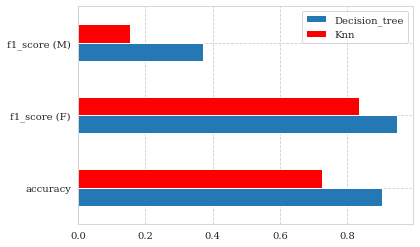

In [107]:
combined_dic_rus = combined_results(decision_tree_rus,knn_rus)
df = pd.DataFrame(combined_dic_rus)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('RandomUndersampling_Vocal_Channel_Result',dpi=300, bbox_inches='tight')
plt.show()

## Edited Nearest Neighbors

In [108]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [109]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [110]:
X_res_enn_knn, y_res_enn_knn = enn(X_train_knn, y_train_knn)

In [111]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({0: 617, 1: 27})


In [112]:
print('Resampled dataset shape %s' % Counter(y_res_enn_knn))

Resampled dataset shape Counter({0: 617, 1: 22})


In [113]:
knn_under_enn = Knn(X_res_enn_knn, y_res_enn_knn)

In [114]:
print(knn_under_enn.best_params_)

{'weights': 'distance', 'n_neighbors': 207, 'metric': 'cosine'}


In [116]:
model_knn_enn = KNeighborsClassifier(weights = 'distance', 
                                     n_neighbors = 207, 
                                     metric = 'cosine')
model_knn_enn.fit(X_res_enn_knn, y_res_enn_knn)

KNeighborsClassifier(metric='cosine', n_neighbors=207, weights='distance')

In [117]:
y_pred_knn_under_enn =model_knn_enn.predict(X_test_knn)

In [118]:
knn_enn = metrics_model(y_test_knn, y_pred_knn_under_enn, 'F', 'M')
knn_enn

{'accuracy': 0.942652329749104,
 'f1_score (F)': 0.970479704797048,
 'f1_score (M)': 0.0}

In [119]:
print(classification_report(y_test_knn, y_pred_knn_under_enn))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       264
           1       0.00      0.00      0.00        15

    accuracy                           0.94       279
   macro avg       0.47      0.50      0.49       279
weighted avg       0.90      0.94      0.92       279



## Decision Tree after EditedNearestNeighbors

In [ ]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn)

In [ ]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

In [ ]:
model_tree_enn = DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth = 198, 
                                        min_samples_leaf = 0.008600050187994722, 
                                        min_samples_split = 0.016951406082573145)
model_tree_enn.fit(X_res_enn, y_res_enn)

In [ ]:
y_pred_decision_tree_under_enn = model_tree_enn.predict(X_test)

In [ ]:
decision_tree_enn = metrics_model(y_test,y_pred_decision_tree_under_enn, 'F', 'M')
decision_tree_enn

In [ ]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

In [ ]:
combined_dic_enn = combined_results(decision_tree_enn,knn_enn)
df = pd.DataFrame(combined_dic_enn)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('RandomUndersampling_Result',dpi=300, bbox_inches='tight')
plt.show()

## Oversampling

In [120]:
from imblearn.over_sampling import SMOTE

## SMOTE

In [121]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [122]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [123]:
X_res_sm_knn, y_res_sm_knn = smote(X_train_knn, y_train_knn)

In [124]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({0: 623, 1: 623})


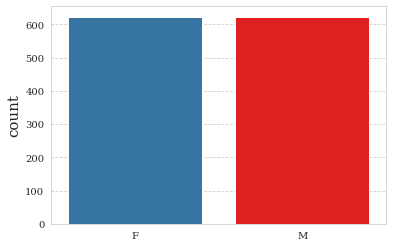

In [125]:
labels = ['F','M']
ax=sns.countplot(x=y_res_sm, palette=['#2478b4','#ff0000'])
ax.set_xticklabels(labels)
img_name = 'RandomUndersampling_Sex' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

## KNN after SMOTE

In [126]:
knn_over_sm = Knn(X_res_sm_knn, y_res_sm_knn)

In [127]:
print(knn_over_sm.best_params_)

{'weights': 'distance', 'n_neighbors': 12, 'metric': 'cosine'}


In [128]:
model_knn_smote = KNeighborsClassifier(weights = 'distance', 
                                       n_neighbors = 12, 
                                       metric = 'cosine')
model_knn_smote.fit(X_res_sm_knn, y_res_sm_knn)

KNeighborsClassifier(metric='cosine', n_neighbors=12, weights='distance')

In [129]:
y_pred_knn_over_sm = model_knn_smote.predict(X_test_knn)

In [130]:
knn_smote = metrics_model(y_test_knn, y_pred_knn_over_sm, 'F', 'M')
knn_smote

{'accuracy': 0.946236559139785,
 'f1_score (F)': 0.9722735674676525,
 'f1_score (M)': 0.11764705882352941}

In [131]:
print(classification_report(y_test_knn, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       264
           1       0.50      0.07      0.12        15

    accuracy                           0.95       279
   macro avg       0.72      0.53      0.54       279
weighted avg       0.93      0.95      0.93       279



## Decision Tree after SMOTE


In [132]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm)

In [133]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'log_loss', 'max_depth': 57, 'min_samples_leaf': 0.001964735338974454, 'min_samples_split': 0.03030402939925027}


In [134]:
model_tree_smote = DecisionTreeClassifier(criterion = 'log_loss',
                                          max_depth = 57,
                                          min_samples_leaf = 0.001964735338974454,
                                          min_samples_split = 0.03030402939925027)
model_tree_smote.fit(X_res_sm, y_res_sm)

DecisionTreeClassifier(criterion='log_loss', max_depth=57,
                       min_samples_leaf=0.001964735338974454,
                       min_samples_split=0.03030402939925027)

In [135]:
y_pred_decision_tree_over_sm = model_tree_smote.predict(X_test)

In [136]:
decision_tree_smote = metrics_model( y_test, y_pred_decision_tree_over_sm,'F', 'M')
decision_tree_smote

{'accuracy': 0.956989247311828,
 'f1_score (F)': 0.9774436090225563,
 'f1_score (M)': 0.5384615384615384}

In [137]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       269
           1       0.44      0.70      0.54        10

    accuracy                           0.96       279
   macro avg       0.71      0.83      0.76       279
weighted avg       0.97      0.96      0.96       279



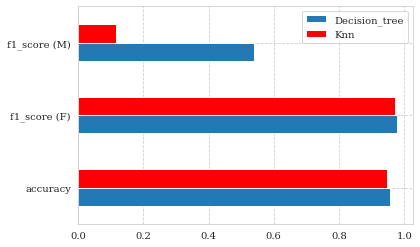

In [138]:
combined_dic = combined_results(decision_tree_smote,knn_smote)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('SMOTE_Sex_Result',dpi=300, bbox_inches='tight')
plt.show()